# Sentiment Analysis for Wine Reviews
## Goal: use natural language processing to predict wine review scores from the review text
For the **rough draft**, start simple by adapting the movie review sentiment analysis from https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

## Conclusion
The simple Logistic model without any hyperparameter tuning or advanced feature engineering achieved >97% accuracy in the testing set. This seems too good to be true (the movie review example got 88%). Then again, most of the positive and negative words are logical (e.g. 'beautiful' vs 'thin). 

## TODO 
- Regression rather than classification 
- What are other features to use? I know review length for one is correlated with score. Can I use punctuation? 
- Text Processing: Stemming/Lemmatizing to convert different forms of each word into one.
- n-grams: Instead of just single-word tokens (1-gram/unigram) we can also include word pairs.
- Representations: Instead of simple, binary vectors we can use word counts or TF-IDF to transform those counts.
- Algorithms: In addition to Logistic Regression, we’ll see how Support Vector Machines perform.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
df = pd.read_csv('../input/winemag-data_first150k.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


(array([ 2400., 10089., 23119., 36320., 30792., 26509., 15258.,  5178.,
         1060.,   205.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 10 Patch objects>)

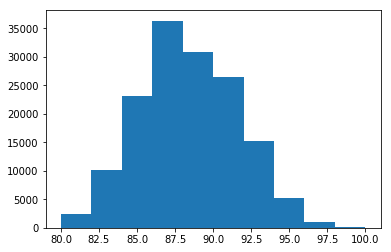

In [43]:
plt.hist(df.points)

In [39]:
df.points.describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [42]:
df.points.describe()['75%']
df.points.describe()['25%']

86.0

# Binary quality classification
Points range from 80 to 100 (mean is 87). For binary classification, let's start with saying top quartile is "good" and bottom quartile is "bad"

In [46]:
df['Target'] = np.NaN
df.loc[df['points'] > df.points.describe()['75%'], 'Target'] = 1
df.loc[df['points'] < df.points.describe()['25%'], 'Target'] = 0

In [47]:
df.Target.value_counts()

0.0    35608
1.0    32237
Name: Target, dtype: int64

In [49]:
df = df.dropna(subset=['Target'])
print(len(df))
df.Target.value_counts()

67845


0.0    35608
1.0    32237
Name: Target, dtype: int64

In [56]:
reviews = df.description.tolist()
target = df.Target

# NLP processing

In [51]:
reviews[0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

In [52]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def remove_non_letters(review):
    words = ''.join([x + '' for x in review if x in string.ascii_letters + ' '])
    return re.sub('  ', ' ', words)
    
def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    reviews = [remove_non_letters(r) for r in reviews]
    
    return reviews

reviews_clean = preprocess_reviews(reviews)

In [53]:
reviews_clean[0]

'this tremendous varietal wine hails from oakville and was aged over three years in oak juicy red cherry fruit and a compelling hint of caramel greet the palate framed by elegant fine tannins and a subtle minty tone in the background balanced and rewarding from start to finish it has years ahead of it to develop further nuance enjoy '

In [68]:
reviews_train, reviews_test, target_train, target_test = train_test_split(reviews_clean, target, test_size=0.25, random_state=42)

In [69]:
%%time
cv = CountVectorizer(binary=True)
cv.fit(reviews_train)
X_train = cv.transform(reviews_train)
X_test = cv.transform(reviews_test)

Wall time: 4.13 s


In [70]:
X_train.shape

(50883, 22624)

In [71]:
%%time
model = LogisticRegression()
model.fit(X_train, target_train)
accuracy = accuracy_score(target_test, model.predict(X_test))
print (f'Final Accuracy: {accuracy}')

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Accuracy: 0.975828322131824
Wall time: 1.85 s


In [76]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), model.coef_[0]
    )
}

print('Most positively associated words')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)
    
print('\n Most negatively associated words')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)
    

Most positively associated words
('sample', 5.001440143716971)
('beautiful', 2.957740828888433)
('intrude', 2.860024608013748)
('succulent', 2.708877256372239)
('beautifully', 2.6263412917994007)
('complex', 2.469392445489926)
('excellent', 2.451537144759422)
('lovely', 2.388433054044671)
('delicious', 2.3868519867434452)
('wonderful', 2.3717357205341663)

 Most negatively associated words
('everyday', -2.713167101456309)
('lacks', -2.4992873895733916)
('my', -2.39507083962599)
('sugary', -2.3098499785933524)
('short', -2.2745446276138432)
('simple', -2.152292842307332)
('decent', -2.11088433049747)
('stalky', -2.1053146399008074)
('thin', -1.973519669889102)
('vegetal', -1.9406246881355291)
